### Starting to think a bit about trends.
1. compute some regionally-averaged metric (surface chl, NPP, etc.) 
2. plot its timeseries, 1920-2100. 
* start with the single run
* expand to include the full ensemble

I can help if you get stuck. Don't flounder around too long before asking for help.

In [1]:
%matplotlib inline
import os
import importlib
import pandas as pd
import numpy as np
import xarray as xr
import calendar
import cftime

import xesmf as xe
import dask
from ncar_jobqueue import NCARCluster
import esmlab
import warnings
warnings.filterwarnings('ignore')
from glob import glob
from collections import OrderedDict

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import matplotlib.path as mpath

import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import cmocean
from scipy import stats
import pop_tools 

from statistics import mean
from matplotlib import style
from scipy import stats

import util
import shutil

Cannot write to data cache '/glade/p/cesmdata/cseg'. Will not be able to download remote data files. Use environment variable 'CESMDATAROOT' to specify another directory.


In [2]:
'''from ncar_jobqueue import NCARCluster
#cluster = NCARCluster()
cluster = NCARCluster(project='UCUC0006')
cluster.scale(36) #adapt(minimum_jobs=1, maximum_jobs=40)
cluster
''';

In [3]:
'''
from dask.distributed import Client
client = Client(cluster) # Connect this local process to remote workers
client
''';

#### Read in data: Open files and read in monthly data

 Xarray's ``open_mfdataset`` (open multi-file dataset) method will attempt to
 merge all of the individual datasets (i.e., NetCDF files) into one single
 Xarray ``Dataset``.  The ``concat_dim`` and ``combine`` keyword arguments to
 this method give you control over how this merging takes place (see the
 Xarray documentation for more information).


In [2]:
cesmle_root = '/glade/p/cesm/community/CESM-LE/data/CESM-CAM5-BGC-LE'

component = 'ocn'
freq = 'monthly'
stream = 'pop.h' # POP ocean model monthly stream
case = 'b.e11.B20TRC5CNBDRD.f09_g16.001'

variables = ['SST', 'diatChl', 'spChl', 'diazChl']
grid_vars = ['KMT', 'TAREA', 'TLAT', 'TLONG', 'z_t', 'dz', 'z_t_150m', 'time', 'time_bound']

# loop over variables, construct list of datasets
ds_list = []
for v in variables:
    files = glob(f'{cesmle_root}/{component}/proc/tseries/{freq}/{v}/{case}.{stream}.{v}.*.nc')
    dsi = xr.open_mfdataset(files, decode_coords=False, decode_times=False, 
                            concat_dim='time',
                            combine='nested',
                            data_vars=[v],
                            chunks={'nlon': 16})
    # SST has a singleton z_t dimension, so remove this to avoid problems on merge
    if v == 'SST':
        dsi = dsi.squeeze(dim='z_t', drop=True).drop('dz')
        
        
    ds_list.append(dsi)
    
ds = xr.merge(ds_list)
ds = ds[variables+grid_vars]

ds['time'] = xr.DataArray(cftime.num2date(ds.time_bound.mean(dim='d2'), units=ds.time.units, 
                                         calendar=ds.time.calendar), dims=('time'))

ds['Chl_surf'] = (ds.diatChl + ds.spChl + ds.diazChl).isel(z_t_150m=0)
ds.Chl_surf.attrs = ds.diatChl.attrs
ds.Chl_surf.attrs['long_name'] = 'Surface chlorophyll'

variables = list(filter(lambda v: 'Chl' not in v, variables)) + ['Chl_surf']
ds = ds[variables+grid_vars]
ds

<xarray.Dataset>
Dimensions:     (d2: 2, nlat: 384, nlon: 320, time: 1872, z_t: 60, z_t_150m: 15)
Coordinates:
  * z_t         (z_t) float32 500.0 1500.0 2500.0 ... 512502.8 537500.0
  * z_t_150m    (z_t_150m) float32 500.0 1500.0 2500.0 ... 13500.0 14500.0
  * time        (time) object 1850-01-17 00:30:00 ... 2005-12-16 12:00:00
Dimensions without coordinates: d2, nlat, nlon
Data variables:
    SST         (time, nlat, nlon) float32 dask.array<chunksize=(1872, 384, 16), meta=np.ndarray>
    Chl_surf    (time, nlat, nlon) float32 dask.array<chunksize=(1872, 384, 16), meta=np.ndarray>
    KMT         (nlat, nlon) float64 dask.array<chunksize=(384, 16), meta=np.ndarray>
    TAREA       (nlat, nlon) float64 dask.array<chunksize=(384, 16), meta=np.ndarray>
    TLAT        (nlat, nlon) float64 dask.array<chunksize=(384, 16), meta=np.ndarray>
    TLONG       (nlat, nlon) float64 dask.array<chunksize=(384, 16), meta=np.ndarray>
    dz          (z_t) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    time_bound  (time, d2) float64 dask.array<chunksize=(1872, 2), meta=np.ndarray>

In [3]:
variables = ['SST', 'Chl_surf', 'KMT', 'TAREA', 'TLAT', 'TLONG', 'z_t', 'dz', 'z_t_150m', 'time_bound']

In [4]:
## Clip to 1986 to 2005:
#ds = ds[variables].isel(time=slice(1632, 1872)).groupby('time.month').mean('time')
## Clip to 1920 - end:
#ds = ds[variables].isel(time=slice(840, 1872))
## Clip to 1996 to 2005:
ds_10 = ds[variables].isel(time=slice(1752, 1872))
ds10_mon = ds[variables].isel(time=slice(1752, 1872)).groupby('time.month').mean('time')
ds10_ann = ds[variables].isel(time=slice(1752, 1872)).groupby('time.year').mean('time')

## Make Regional Masks and Check Them:

In [5]:
#make masks on grid:
grid_name = 'POP_gx1v7'
grid = pop_tools.get_grid(grid_name)

In [6]:
# Set it up:
lat = grid.TLAT
lon = grid.TLONG

In [7]:
# Mask out rectangles:
atl_mask = grid.TAREA.where((lat <= -45) & ((lon > 295) | (lon <= 55)) & (grid.REGION_MASK == 1)).fillna(0.) # ATLANTIC
ind_mask = grid.TAREA.where((lat <= -45) & ((lon > 55) & (lon <= 145)) & (grid.REGION_MASK == 1)).fillna(0.) # INDIAN
wpac_mask = grid.TAREA.where((lat <= -45) & ((lon > 145) & (lon <= 245)) & (grid.REGION_MASK == 1)).fillna(0.) # WEST PACIFIC
epac_mask = grid.TAREA.where((lat <= -45) & ((lon >= 245) & (lon <= 298)) & (grid.REGION_MASK == 1)).fillna(0.) # EAST PACIFIC

SO_mask = grid.TAREA.where((lat <= -45) & (grid.REGION_MASK == 1)).fillna(0.) #Southern Ocean

In [8]:
rmask = xr.DataArray(np.ones(5), dims='region') * grid.TAREA
rmask[0, :, :] = grid.TAREA.where((lat <= -45) & (grid.REGION_MASK == 1)).fillna(0.) #Southern Ocean
rmask[1, :, :] = grid.TAREA.where((lat <= -45) & ((lon > 295) | (lon <= 55)) & (grid.REGION_MASK == 1)).fillna(0.) # ATLANTIC
rmask[2, :, :] = grid.TAREA.where((lat <= -45) & ((lon > 55) & (lon <= 145)) & (grid.REGION_MASK == 1)).fillna(0.) # INDIAN
rmask[3, :, :] = grid.TAREA.where((lat <= -45) & ((lon > 145) & (lon <= 245)) & (grid.REGION_MASK == 1)).fillna(0.) # WEST PACIFIC
rmask[4, :, :] = grid.TAREA.where((lat <= -45) & ((lon >= 245) & (lon <= 298)) & (grid.REGION_MASK == 1)).fillna(0.) # EAST PACIFIC

## Decadal Distribution of Chl by Region

Create Seasonally Averaged Data

In [10]:
# calculate time series of seasonal data using `where` and `rolling`
# mask other months with nan
ds_DJF = ds_10.where(ds_10['time.season'] == 'DJF')
# rolling mean -> only Jan is not nan
# however, we loose Jan/ Feb in the first year and Dec in the last
ds_DJF = ds_DJF.rolling(min_periods=3, center=True, time=3).mean()
# make annual mean
ds_DJF = ds_DJF.groupby('time.year').mean('time')
ds_DJF

# error ds_DJF.isel(year = '2000').plot()

<xarray.Dataset>
Dimensions:     (d2: 2, nlat: 384, nlon: 320, year: 10, z_t: 60, z_t_150m: 15)
Coordinates:
  * z_t         (z_t) float32 500.0 1500.0 2500.0 ... 512502.8 537500.0
  * z_t_150m    (z_t_150m) float32 500.0 1500.0 2500.0 ... 13500.0 14500.0
  * year        (year) int64 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005
Dimensions without coordinates: d2, nlat, nlon
Data variables:
    SST         (year, nlat, nlon) float32 dask.array<chunksize=(1, 384, 16), meta=np.ndarray>
    Chl_surf    (year, nlat, nlon) float32 dask.array<chunksize=(1, 384, 16), meta=np.ndarray>
    KMT         (year, nlat, nlon) float64 dask.array<chunksize=(1, 384, 16), meta=np.ndarray>
    TAREA       (year, nlat, nlon) float64 dask.array<chunksize=(1, 384, 16), meta=np.ndarray>
    TLAT        (year, nlat, nlon) float64 dask.array<chunksize=(1, 384, 16), meta=np.ndarray>
    TLONG       (year, nlat, nlon) float64 dask.array<chunksize=(1, 384, 16), meta=np.ndarray>
    dz          (year, z_t) float32 dask.array<chunksize=(1, 60), meta=np.ndarray>
    time_bound  (year, d2) float64 dask.array<chunksize=(1, 2), meta=np.ndarray>

In [11]:
#Log transform the data
log_trans = np.log10(ds_DJF.Chl_surf.where(ds_DJF.Chl_surf>0))

In [ ]:
#Make them a vector
s10 = log_trans.values.ravel()

In [19]:
#Log transform the data
mod_log_trans = np.log10(ds_DJF.Chl_surf.where(ds_DJF.Chl_surf>0))
obs_log_trans = np.log10(ds_DJF.chl_gsm.where(dsobs.chl_gsm>0))
#Make them a vector
S_obs = obs_log_trans.values.ravel()
S_sim = mod_log_trans.values.ravel()
#Plot!
plt.figure(figsize=(10, 5))
plt.hist(S_obs, 100, density=True, label='Observation 1997-2005');
plt.hist(S_sim, 100, density=True, alpha=0.5, label='Model 1986-2005');
plt.xlabel('S')
plt.title('Global Chlorophyll-a PDF')
plt.ylabel('Density');
plt.legend();
#plt.savefig('Global-Chl_seawifs-v-cesm.png')

### Calc Regional Means


In [20]:
#Using the rmask ds....
sst_so_mean = (ds.SST * rmask.isel(region=0)).sum(['nlat', 'nlon']) / rmask.isel(region=0).sum(['nlat', 'nlon'])
sst_so_mean = sst_so_mean.compute()

sst_atl_mean = (ds.SST * rmask.isel(region=1)).sum(['nlat', 'nlon']) / rmask.isel(region=1).sum(['nlat', 'nlon'])
sst_atl_mean = sst_atl_mean.compute()

sst_ind_mean = (ds.SST * rmask.isel(region=2)).sum(['nlat', 'nlon']) / rmask.isel(region=2).sum(['nlat', 'nlon'])
sst_ind_mean = sst_ind_mean.compute()

sst_wpac_mean = (ds.SST * rmask.isel(region=3)).sum(['nlat', 'nlon']) / rmask.isel(region=3).sum(['nlat', 'nlon'])
sst_wpac_mean = sst_wpac_mean.compute()

sst_epac_mean = (ds.SST * rmask.isel(region=4)).sum(['nlat', 'nlon']) / rmask.isel(region=4).sum(['nlat', 'nlon'])
sst_epac_mean = sst_epac_mean.compute()

In [12]:
#using the singular masks (less computing)
chl_so_mean = (ds.Chl_surf * SO_mask).sum(['nlat', 'nlon']) / SO_mask.sum(['nlat', 'nlon'])
chl_so_mean = chl_so_mean.compute()

chl_ind_mean = (ds.Chl_surf * atl_mask).sum(['nlat', 'nlon']) / atl_mask.sum(['nlat', 'nlon'])
chl_ind_mean = chl_ind_mean.compute()

chl_atl_mean = (ds.Chl_surf * ind_mask).sum(['nlat', 'nlon']) / ind_mask.sum(['nlat', 'nlon'])
chl_atl_mean = chl_atl_mean.compute()

chl_wpac_mean = (ds.Chl_surf * wpac_mask).sum(['nlat', 'nlon']) / wpac_mask.sum(['nlat', 'nlon'])
chl_wpac_mean = chl_wpac_mean.compute()

chl_epac_mean = (ds.Chl_surf * epac_mask).sum(['nlat', 'nlon']) / epac_mask.sum(['nlat', 'nlon'])
chl_epac_mean = chl_epac_mean.compute()

In [25]:
sst_atl_mean = (ds.SST * atl_mask).sum(['nlat', 'nlon']) / atl_mask.sum(['nlat', 'nlon'])
sst_atl_mean = sst_atl_mean.compute()

sst_ind_mean = (ds.SST * ind_mask).sum(['nlat', 'nlon']) / ind_mask.sum(['nlat', 'nlon'])
sst_ind_mean = sst_ind_mean.compute()

sst_wpac_mean = (ds.SST * wpac_mask).sum(['nlat', 'nlon']) / wpac_mask.sum(['nlat', 'nlon'])
sst_wpac_mean = sst_wpac_mean.compute()

sst_epac_mean = (ds.SST * epac_mask).sum(['nlat', 'nlon']) / epac_mask.sum(['nlat', 'nlon'])
sst_epac_mean = sst_epac_mean.compute()

### Plot Chl
style.use('ggplot')
sns.set_style("darkgrid")

In [16]:
import seaborn as sns
#sns.set_style("darkgrid")
#style.use('seaborn')
style.use('ggplot')

In [15]:
#for saving figures:
pwd = os.getcwd()
os.chdir('/glade/u/home/zephyrs/projects/krill-cesm-le/figures')
pwd

'/glade/u/home/zephyrs/projects/krill-cesm-le/figures'

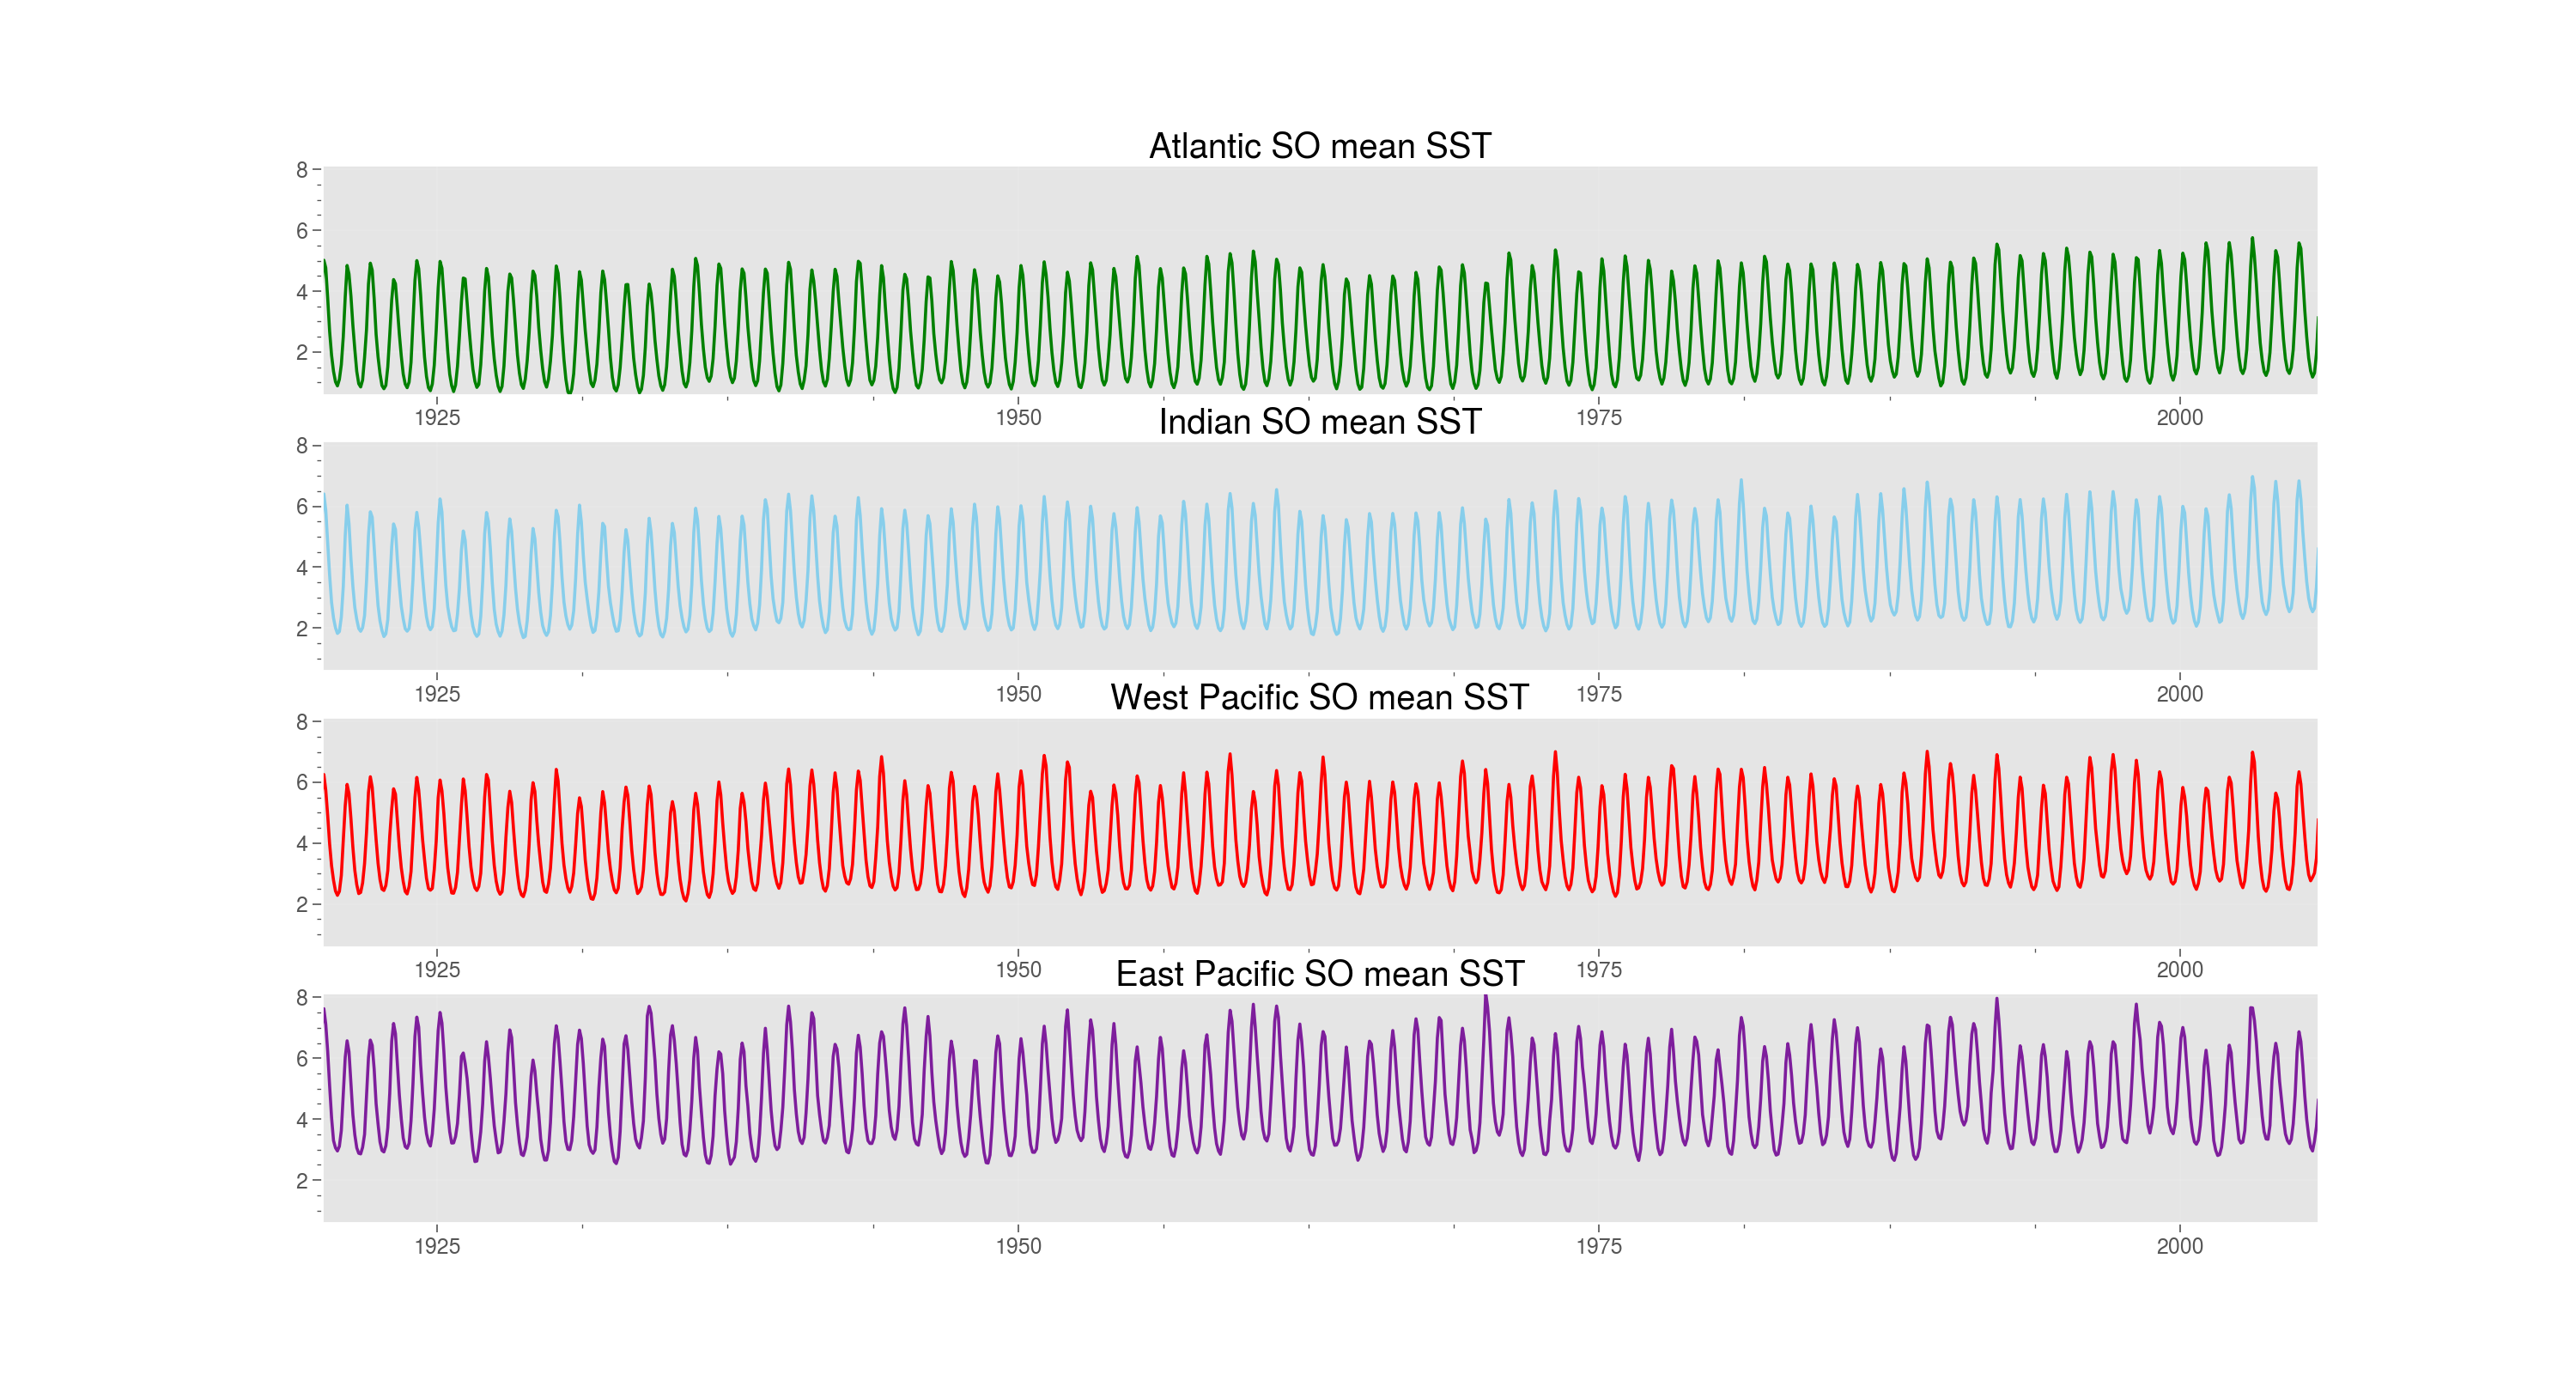

In [21]:
# Plot all Basins
fig = plt.figure(figsize=(10,4))

ax1 = fig.add_subplot(414)
ax1.set_title('East Pacific SO mean SST')
ax1.plot(sst_epac_mean['time'].values, sst_epac_mean.values, color = 'purple')
plt.gca()

ax2 = fig.add_subplot(412,sharex=ax1, sharey=ax1 )
ax2.set_title('Indian SO mean SST')
ax2.plot(sst_ind_mean['time'].values, sst_ind_mean.values, color = 'skyblue')
plt.gca()

ax3 = fig.add_subplot(411,sharex=ax1, sharey=ax1)
ax3.set_title('Atlantic SO mean SST')
ax3.plot(sst_atl_mean['time'].values, sst_atl_mean.values, color = 'green')
plt.gca()

ax3 = fig.add_subplot(413, sharex=ax1, sharey=ax1)
ax3.set_title('West Pacific SO mean SST')
ax3.plot(sst_wpac_mean['time'].values, sst_wpac_mean.values, color = 'red')
plt.gca()

plt.savefig('CESM-SST-TIMESERIES-BYBASIN-INDIVID.png')

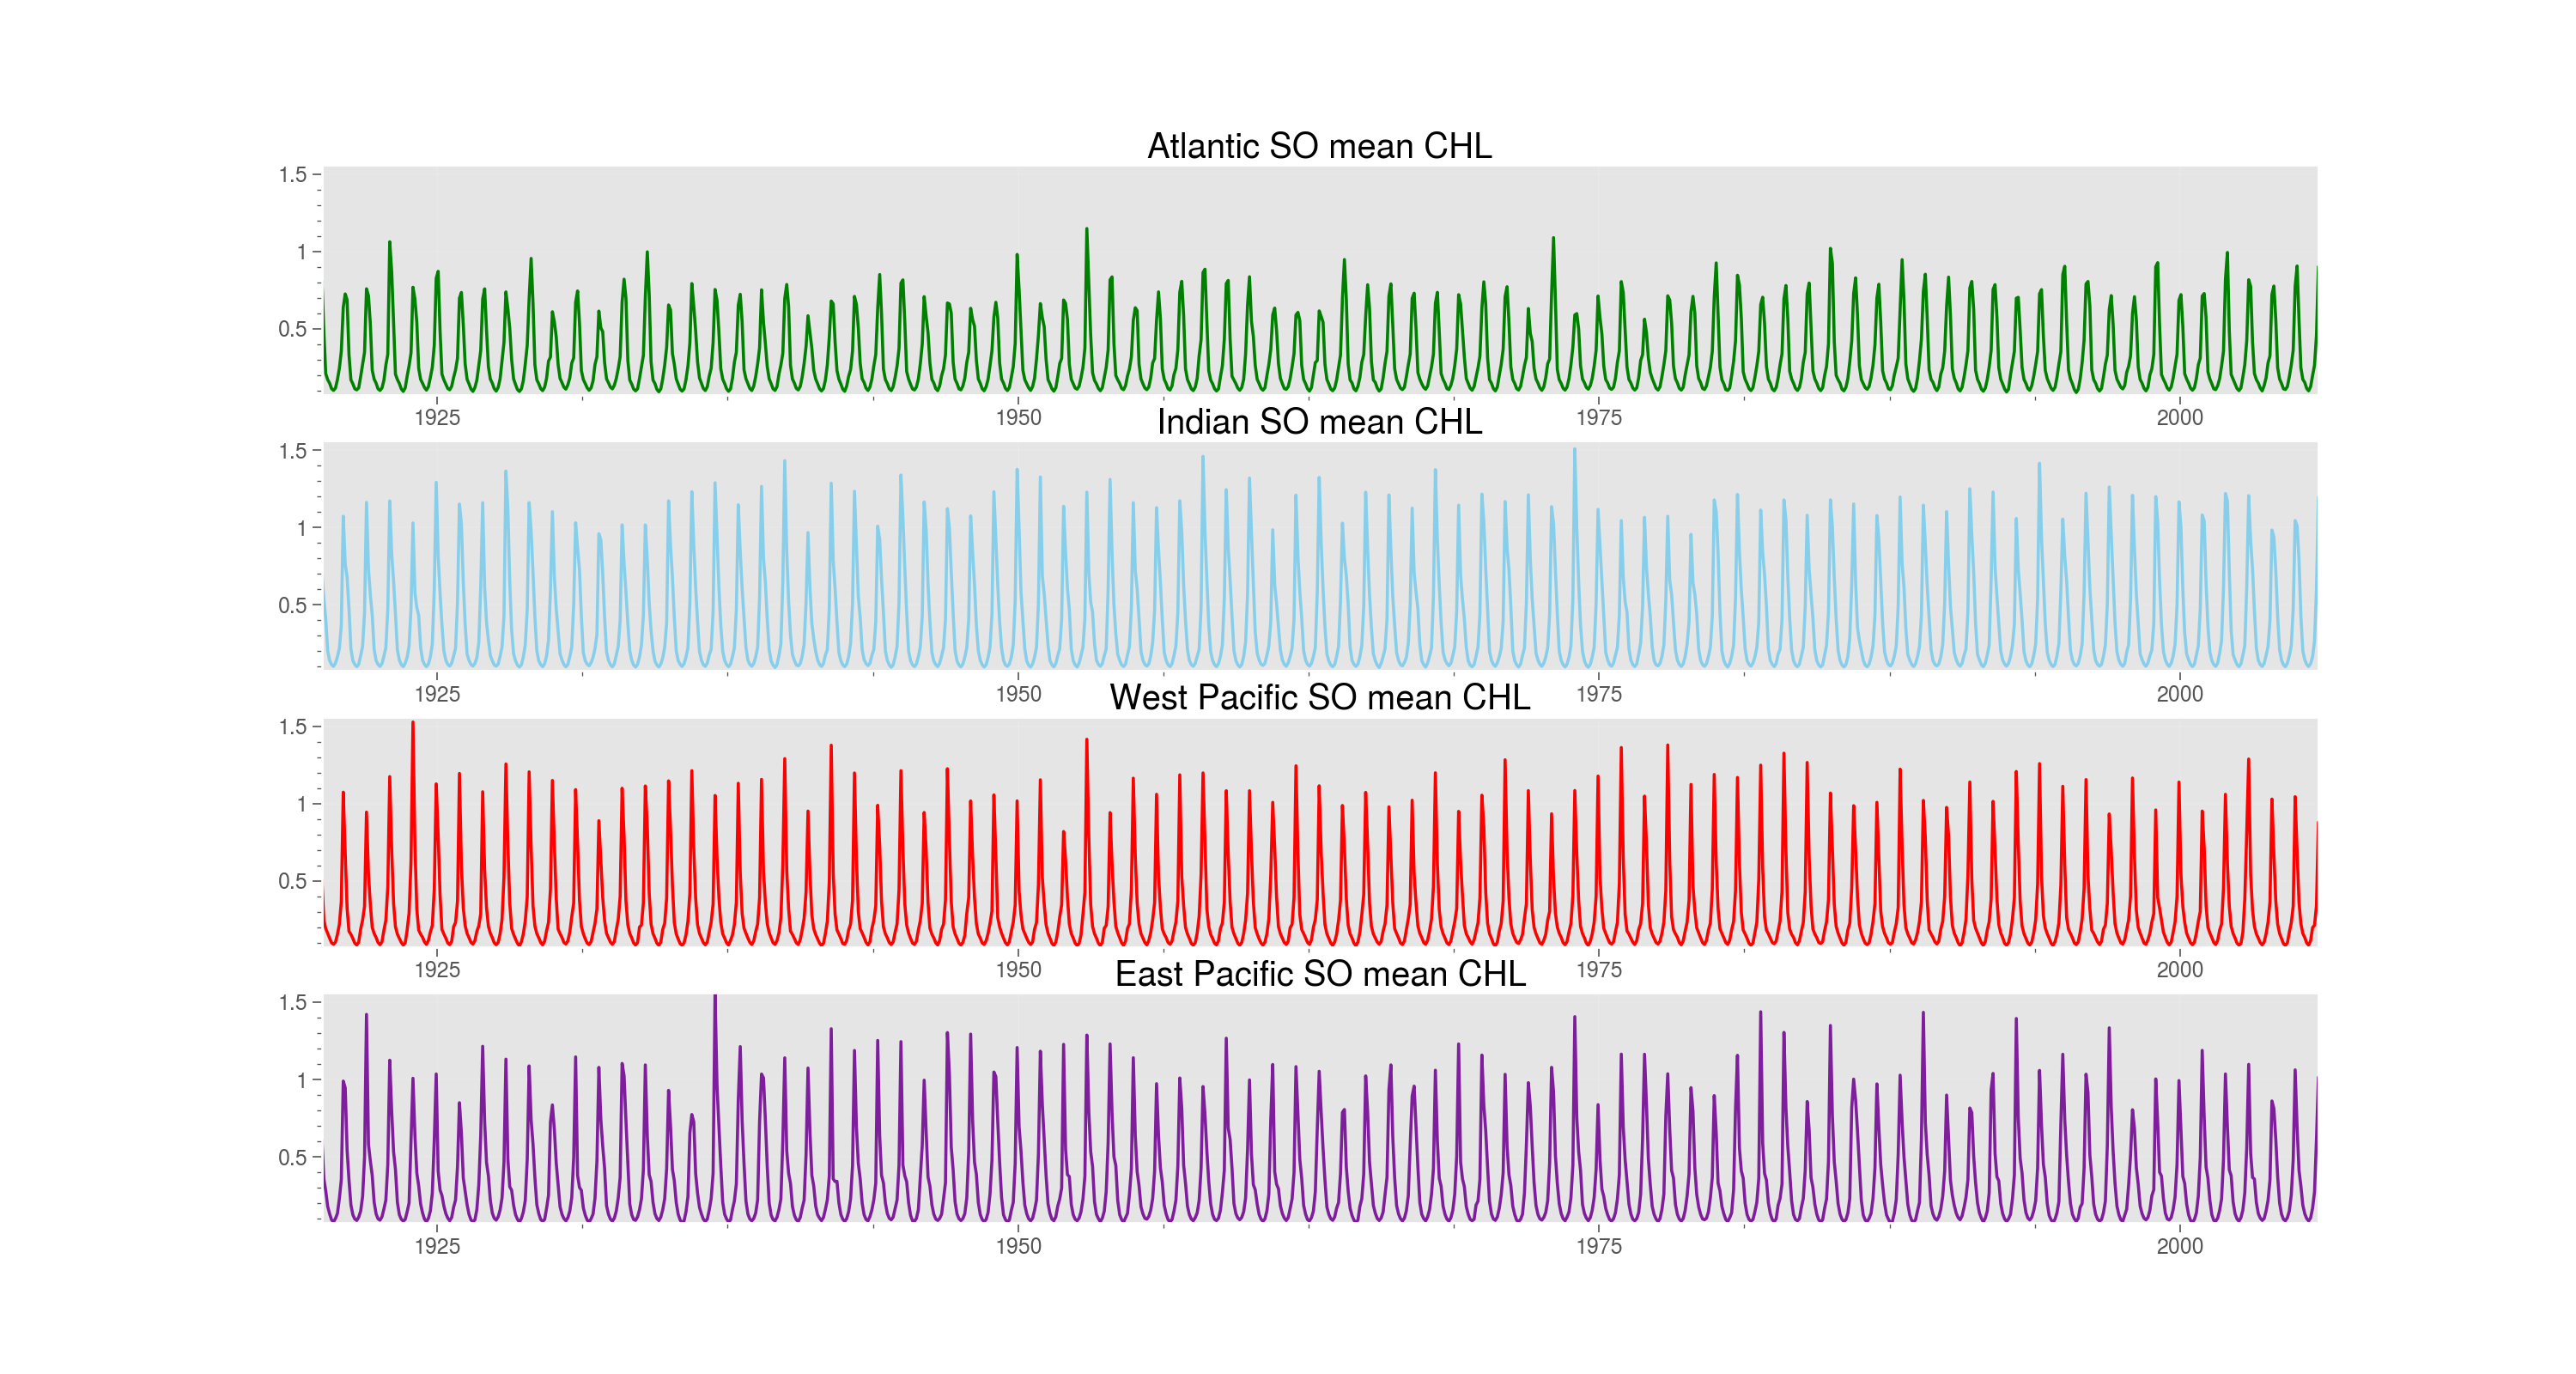

In [19]:
# Plot all Basins
fig = plt.figure(figsize=(10,4))

ax1 = fig.add_subplot(414)
ax1.set_title('East Pacific SO mean CHL')
ax1.plot(chl_epac_mean['time'].values, chl_epac_mean.values, color = 'purple')
plt.gca()

ax2 = fig.add_subplot(412,sharex=ax1, sharey=ax1 )
ax2.set_title('Indian SO mean CHL')
ax2.plot(chl_ind_mean['time'].values, chl_ind_mean.values, color = 'skyblue')
plt.gca()

ax3 = fig.add_subplot(411,sharex=ax1, sharey=ax1)
ax3.set_title('Atlantic SO mean CHL')
ax3.plot(chl_atl_mean['time'].values, chl_atl_mean.values, color = 'green')
plt.gca()

ax3 = fig.add_subplot(413, sharex=ax1, sharey=ax1)
ax3.set_title('West Pacific SO mean CHL')
ax3.plot(chl_wpac_mean['time'].values, chl_wpac_mean.values, color = 'red')
plt.gca()

plt.savefig('CESM-CHL-TIMESERIES-BYBASIN-INDIVID.png')

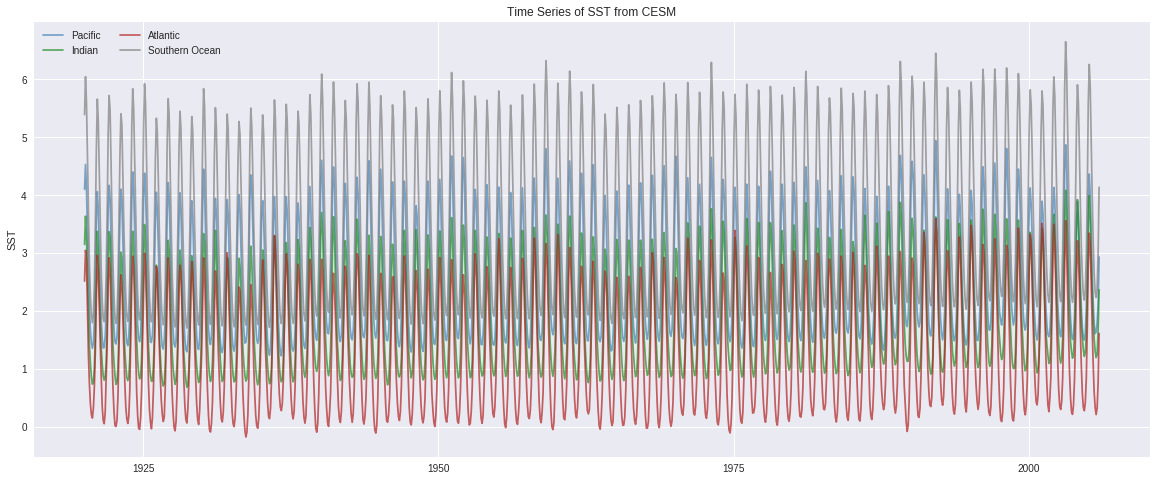

In [138]:
# Plot all Basins
fig = plt.figure(figsize=(20,8))

ax = fig.add_subplot(111)
ax.set_title('Time Series of SST from CESM')

ax.plot(sst_pac_mean['time'].values, sst_pac_mean.values, alpha=0.7, label = 'Pacific', color = 'steelblue')
ax.plot(sst_ind_mean['time'].values, sst_ind_mean.values, alpha=0.7, label = 'Indian', color = 'forestgreen')
ax.plot(sst_atl_mean['time'].values, sst_atl_mean.values, alpha=0.7, label = 'Atlantic', color = 'firebrick')
ax.plot(sst_so_mean['time'].values, sst_so_mean.values, alpha=0.7, label = 'Southern Ocean', color = 'grey')

ax.legend(ncol=2)
ax.set(ylabel='SST')
plt.gca()

#plt.savefig('CESM-SST-TIMESERIES-BYBASIN.png')

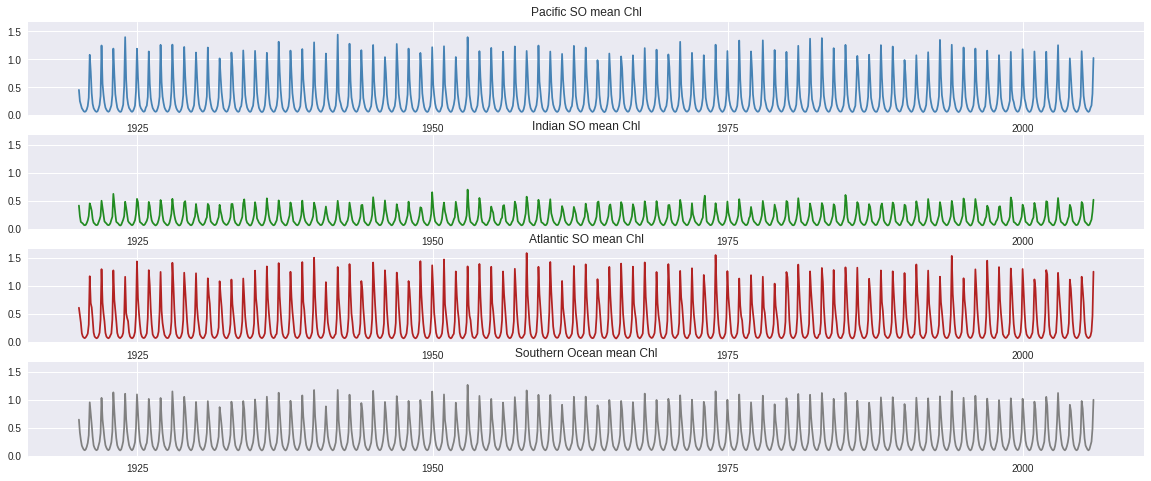

In [145]:
# Plot all Basins
fig = plt.figure(figsize=(20,8))

ax1 = fig.add_subplot(411)
ax1.set_title('Atlantic SO mean Chl')
ax1.plot(chl_atl_mean['time'].values, chl_atl_mean.values, color = 'green')
plt.gca()

ax2 = fig.add_subplot(412,sharex=ax1, sharey=ax1 )
ax2.set_title('Indian SO mean Chl')
ax2.plot(chl_ind_mean['time'].values, chl_ind_mean.values, color = 'skyblue')
plt.gca()

ax3 = fig.add_subplot(413, sharex=ax1, sharey=ax1)
ax3.set_title('Pacific SO mean Chl')
ax3.plot(chl_pac_mean['time'].values, chl_pac_mean.values, color = 'red')
plt.gca()

ax4 = fig.add_subplot(414, sharex=ax1, sharey=ax1)
ax4.set_title('Pacific SO mean Chl')
ax4.plot(chl_pac_mean['time'].values, chl_pac_mean.values, color = 'purple')
plt.gca()

#plt.savefig('CESM-CHL-TIMESERIES-BYBASIN-INDIVID.png')

## Trends?


Make two maps: one of annual mean surface temperature, another of the seasonal range (max minus min).

In [13]:
maxTs = ds.SST.whereatl_mask ).max(dim='time')
minTs = sst_atl_mean.min(dim='time')
meanTs = sst_atl_mean

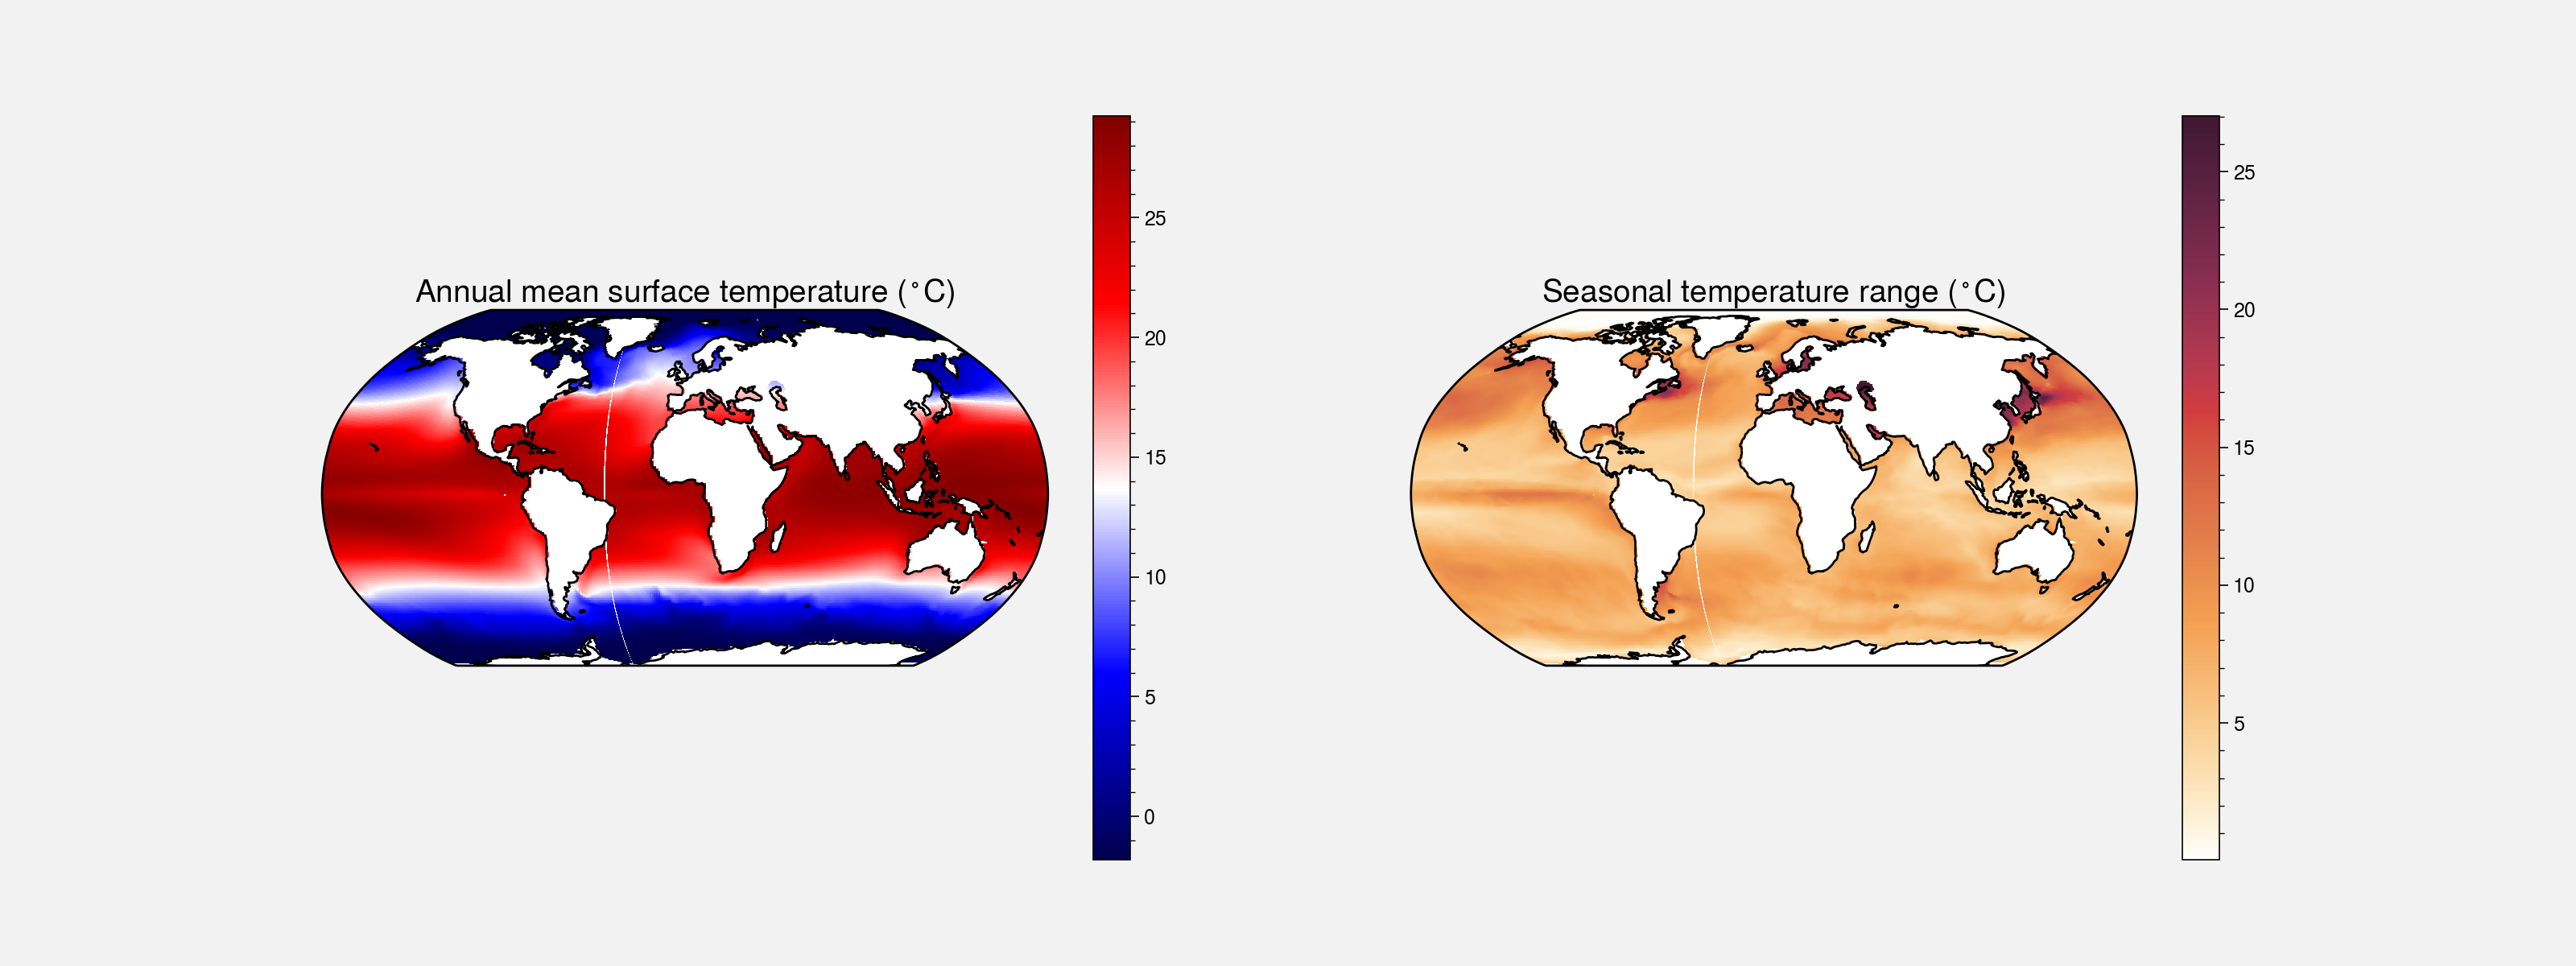

In [16]:
fig = plt.figure( figsize=(16,6) )

ax1 = fig.add_subplot(1,2,1, projection=ccrs.Robinson())
cax1 = ax1.pcolormesh(lon, lat, meanTs, cmap=plt.cm.seismic , transform=ccrs.PlateCarree())
cbar1 = plt.colorbar(cax1)
ax1.set_title('Annual mean surface temperature ($^\circ$C)', fontsize=14 )

ax2 = fig.add_subplot(1,2,2, projection=ccrs.Robinson())
cax2 = ax2.pcolormesh(lon, lat, maxTs - minTs, transform=ccrs.PlateCarree() )
cbar2 = plt.colorbar(cax2)
ax2.set_title('Seasonal temperature range ($^\circ$C)', fontsize=14)

for ax in [ax1,ax2]:
    #ax.contour( lon_cesm, lat_cesm, topo.variables['LANDFRAC'][:], [0.5], colors='k');
    #ax.set_xlabel('Longitude', fontsize=14 ); ax.set_ylabel('Latitude', fontsize=14 )
    ax.coastlines()

In [26]:
sst_so_mean = (ds.SST * rmask.isel(region=0)).sum(['nlat', 'nlon']) / rmask.isel(region=0).sum(['nlat', 'nlon'])
sst_so_mean = sst_so_mean.compute()

In [ ]:
maxTs = ds.SST.where(atl_mask >=0).max(dim='time')
minTs = ds.SST.where(atl_mask >=0).min(dim='time')
meanTs = ds.SST.mean(dim='time')

In [ ]:
#do it for the southern ocean

fig = plt.figure( figsize=(16,6) )

ax1 = fig.add_subplot(1,2,1, projection=ccrs.Robinson())
cax1 = ax1.pcolormesh(lon, lat, meanTs, cmap=plt.cm.seismic , transform=ccrs.PlateCarree())
cbar1 = plt.colorbar(cax1)
ax1.set_title('Annual mean surface temperature ($^\circ$C)', fontsize=14 )

ax2 = fig.add_subplot(1,2,2, projection=ccrs.Robinson())
cax2 = ax2.pcolormesh(lon, lat, maxTs - minTs, transform=ccrs.PlateCarree() )
cbar2 = plt.colorbar(cax2)
ax2.set_title('Seasonal temperature range ($^\circ$C)', fontsize=14)

for ax in [ax1,ax2]:
    #ax.contour( lon_cesm, lat_cesm, topo.variables['LANDFRAC'][:], [0.5], colors='k');
    #ax.set_xlabel('Longitude', fontsize=14 ); ax.set_ylabel('Latitude', fontsize=14 )
    ax.coastlines()

In [17]:
#Polar Plot:

f, axs = plot.subplots(ncols=1, proj = 'splaea', axwidth=3)

axs.pcolormesh(lon, lat, atl_mask_filtered, cmap='green', label = 'Atlantic')
axs.pcolormesh(lon, lat, ind_mask_filtered, cmap='cyan', label = 'Indian')
axs.pcolormesh(lon, lat, wpac_mask_filtered, cmap='red', label = 'West Pacific')
axs.pcolormesh(lon, lat, epac_mask_filtered, cmap='purple',label = 'East Pacific')

axs.format(boundinglat=-40, land = True)

NameError: name 'plot' is not defined

In [25]:
cluster.close()
client.close()

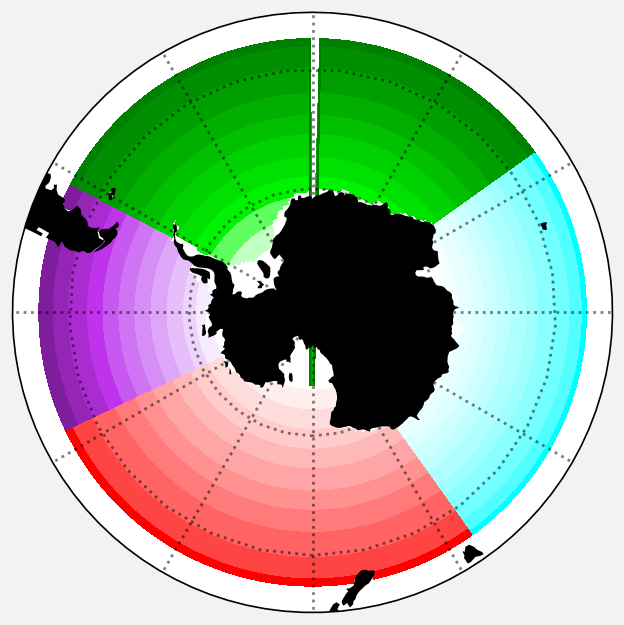

In [22]:
#TO VISUALIZE MASKS:
#Polar Plotting THIS IS WRONG:
threshold = 1.0
atl_mask_filtered = atl_mask.values.copy()
atl_mask_filtered[atl_mask_filtered < threshold] = np.nan

threshold = 1.0
ind_mask_filtered = ind_mask.values.copy()
ind_mask_filtered[ind_mask_filtered < threshold] = np.nan

threshold = 1.0
wpac_mask_filtered = wpac_mask.values.copy()
wpac_mask_filtered[wpac_mask_filtered < threshold] = np.nan

threshold = 1.0
epac_mask_filtered = epac_mask.values.copy()
epac_mask_filtered[epac_mask_filtered < threshold] = np.nan
import proplot as plot
#check all region masks are correct:

#Polar Plot:

f, axs = plot.subplots(ncols=1, proj = 'splaea', axwidth=3)

axs.pcolormesh(lon, lat, atl_mask_filtered, cmap='green', label = 'Atlantic')
axs.pcolormesh(lon, lat, ind_mask_filtered, cmap='cyan', label = 'Indian')
axs.pcolormesh(lon, lat, wpac_mask_filtered, cmap='red', label = 'West Pacific')
axs.pcolormesh(lon, lat, epac_mask_filtered, cmap='purple',label = 'East Pacific')

axs.format(boundinglat=-40, land = True)